# Data Import

In [253]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import string
import matplotlib.pyplot as plt
import csv
import pandas as pd

In [2]:
def normalize_words(text):
    words = text.split()
    norm_words = []
    for word in words:
        lastChar = len(word) - 1 
        if word[0] in ("#","@","(","$","'", '"',"[]") or word[0].isdigit():
            continue
        if word[lastChar].isdigit() or (word[lastChar] in string.punctuation):
            continue
        norm_words.append(word.lower().rstrip(string.punctuation))
    return norm_words

In [3]:
fulltxt = []
for x in range(85):
    filename = '/data/federalist/' + str(x+1) + '.txt'
    with open(filename, 'r') as myfile:
        data = myfile.read().replace('\n', ' ')
        data = normalize_words(data)
        
    fulltxt = fulltxt + data

In [4]:
vocab = {}
for word in fulltxt:
    if word not in vocab:
        vocab[word] = 1
    else:
        vocab[word] += 1

In [5]:
df = pd.Series(vocab)


In [6]:
authors=pd.read_csv("/data/federalist/authorship.csv")

In [7]:
DF=pd.DataFrame(columns=df.index)

In [8]:
for x in range(85):
    filename = '/data/federalist/' + str(x+1) + '.txt'
    with open(filename, 'r') as myfile:
        data = myfile.read().replace('\n', ' ')
        data = normalize_words(data)
        
    article = pd.DataFrame(columns = df.index)
    article.loc[x] = 0
    for word in data:
        if word not in df.index:
            continue
        article[word] = article[word] + 1
        
    DF = DF.append(article)
DF.index = range(1,len(DF)+1)

# Data Wrangling

In [9]:
catCount=DF

In [10]:
#catCount.iloc[18,]

In [11]:
catCount=catCount.reset_index()

In [12]:
catCount=catCount.rename(index=str,columns={"index": "Paper"})

In [13]:
catCount=catCount.merge(authors,how='inner')

In [14]:
sumtotal=catCount.drop('Paper',axis=1).groupby('Author').sum()
grouped=catCount.groupby('Author').sum()
sumtotal=sumtotal.sum(axis=1)

In [15]:
pwa=grouped.T.drop('Paper',axis=0)

In [16]:
pwa=pwa.T

In [17]:
pwa.loc['Hamilton']=pwa.loc['Hamilton']/sumtotal.loc['Hamilton']
pwa.loc['Jay']=pwa.loc['Jay']/sumtotal.loc['Jay']
pwa.loc['Madison']=pwa.loc['Madison']/sumtotal.loc['Madison']

# Initial Approach

In [18]:
"""
Implementation of the EM algorithim for a Poisson distribution with 3 potential authors.
Can be expanded for different lengths.
Assumes document has filtered out all column values that do not appear. 
DOES NOT WORK for greater than/less than 3 authors, does not utilize linear algebra
A good opening step, but needed (and got) update
"""
def EM_Algo(guess,pwapass,documentpass):
    #print("start")
    newguess=pd.DataFrame(pd.Series([10,0,0])).T
    j=0
    pwapass=pwapass[documentpass.index.tolist()]
    while (abs(newguess[0]-guess[0])+abs(newguess[1]-guess[1])+abs(newguess[2]-guess[2]))[0]>.0001: 
        #print("enter")
        if j!=0:
            guess=newguess.copy()
            j+=1
        j+=1
        unnormalized=[]
        paw=[]
        for i in [0,1,2]:
            oneside=np.dot(guess[i],pd.DataFrame(pwapass.iloc[i,:]).T)
            paw.append(oneside)
        for i in range(len(paw[0])):
            s=[paw[j][i] for j in [0,1,2]]
            s=sum(s)
            for k in [0,1,2]:
                paw[k][i]=paw[k][i]/s
        newguess=[np.dot(np.nan_to_num(i),pd.DataFrame(document)) for i in paw]
        newguess=[i/sum(newguess) for i in newguess]
        newguess=[i.tolist()[0] for i in newguess]
        newguess=pd.DataFrame(pd.Series(newguess)).T
    return(newguess)        

In [20]:
# Large and small list of stopwords for restricting
stopwords=["a", "about", "above", "all", "along",
        "also", "although", "am", "an", "and", "any", "are", "as", "at",
        "be", "because", "been", "but", "by", "can", "cannot", "could",
        "did", "do", "does", "either",
        "even", "ever", "enough", "for", "from", "further", "get", "gets", "had", "have",
        "hardly", "has", "having", "he", "hence", "her", "here",
        "him",
        "his", "how", "however", "i", "if", "in", "into", "it", "its",
        "me", "more", "most", "my", "near", "nor", "now", "no", "not", "or", "on", "of",
        "other", "our", "out", "over", "really", "said", "same", "she",
        "should", "since", "so", "some", "such",
        "than", "that", "the", "their", "them", "then", "there", "thereby",
        "therefore", "therein", "thereof",
        "these", "they", "this", "those", "through", "thus", "to",
        "too", "under", "until", "upon", "us", "very", "was",
        "we", "were", "what", "when", "where", "whether",
        "which", "while", "who", "whom", "whose", "why", "with", "without",
        "would", "you"]
stopwords2=["a",'an','and','are','as','at','be','by','for','from','has','he','in','is','it','its','of','on','that','the','to',
          'was','were','will','with']

In [21]:
authors['index']=authors['Paper']
merge=pd.merge(DF.reset_index(),authors).set_index("index")
hamilton=merge.loc[merge['Author']=="Hamilton"].drop(["Author",'Paper'],axis=1)
hamiltonstop=hamilton[stopwords2]
#hamilton=(hamilton.T/hamilton.T.sum(axis=0)).T
jay=merge.loc[merge['Author']=="Jay"].drop(["Author",'Paper'],axis=1)
jaystop=jay[stopwords2]
#jay=(jay.T/jay.T.sum(axis=0)).T
madison=merge.loc[merge['Author']=="Madison"].drop(["Author",'Paper'],axis=1)
madisonstop=madison[stopwords2]
#madison=(madison.T/madison.T.sum(axis=0)).T

# Linear Algebra Approach

In [22]:
"""
Extension of our non linear-algebra approach to linear algebra
Can be used for any number of topics
"""
def EM_Algo_LA(numTopics,pwapass,documentpass):
    j=0
    guess=[]
    ptd=[]
    for i in range(numTopics):
        guess.append(1/numTopics)
    for k in range(documentpass.shape[0]):
        ptd.append(guess)
    ptd=pd.DataFrame(ptd)
    ptd.index=documentpass.index
    B=pwapass
    N=documentpass
    print(j)
    while j<1000:
        if j!=0:
            ptd=newguess.copy().T
        j+=1
        A=ptd
        BA=np.dot(B.T,A.T)
        #print(BA.shape)
        #print(pd.DataFrame(BA).shape,pd.DataFrame(N).shape)
        NBA=(pd.DataFrame(N).T)/BA
        #print(A.shape,np.dot(B,NBA).shape)
        newguess=A.T*np.dot(B,NBA)
        newguess=newguess/newguess.sum(axis=0)
    return(newguess)   

In [23]:
"""
Linear algebra to find topics 
Returns probability of topic for given known document and probability of word given topic
Specify number of topics wanted- unsupervised problem
"""
def doubleUpdate(numTopics,df):
    ptd=[]
    guess=[]
    pwt=[]
    for i in range(numTopics):
        guess.append(1/numTopics)
        pwt.append(np.random.dirichlet(range(df.shape[1]+1)))
    for j in range(df.shape[0]):
        ptd.append(guess)
    ptd=pd.DataFrame(ptd)
    ptd.index=df.index
    pwt=pd.DataFrame(pwt).drop(0,axis=1)
    pwt.columns=df.columns
    #ptdnew=pd.DataFrame(0, columns=ptd.columns, index=ptd.index)
    #pwtnew=pd.DataFrame(0, columns=df.columns,index=pwt.index)
    i=0
    AOLD=pd.DataFrame(0, columns=ptd.columns, index=ptd.index).T
    A=ptd.T
    B=pwt.T # document word
    #return(A-AOLD)
    #while(abs(((A-AOLD)).sum(axis=0).sum())>.0000001):
    while(i<150):
        i+=1
        #print(i)
        AOLD=A.copy()
        BA=np.dot(B,A)
        #print(df.T.shape,BA.shape)
        NBA=df.T/BA
        BNBA=np.dot(B.T,NBA.fillna(0))
        final1=A*BNBA
        final1=pd.DataFrame(final1)/pd.DataFrame(final1).sum(axis=0)
        A=final1
        BA=np.dot(B,A)
        NBA=df.T/BA
        NBAA=np.dot(NBA.fillna(0),A.T)
        final2=B*NBAA
        final2=pd.DataFrame(final2)/pd.DataFrame(final2).sum(axis=0)
        B=final2
        #print((A-AOLD).sum(axis=0).sum())
        #print(A[1])
    return(A,B)

# Sample runs 

In [24]:
madison2=doubleUpdate(2,madison)[1]
madison2.columns=["Madison 0","Madison 1"]
hamilton2=doubleUpdate(2,hamilton)[1]
hamilton2.columns=["Hamilton 0","Hamilton 1"]
jay2=doubleUpdate(2,madison)[1]
jay2.columns=["Jay 0","Jay 1"]

In [25]:
madison2=doubleUpdate(5,madison)[1]
madison2.columns=["Madison 0","Madison 1","Madison2","Madison3","Madison4"]
hamilton2=doubleUpdate(5,hamilton)[1]
hamilton2.columns=["Hamilton 0","Hamilton 1","Hamilton2","Hamilton3","Hamilton4"]
jay2=doubleUpdate(5,jay)[1]
jay2.columns=["Jay 0","Jay 1","Jay 2","Jay 3","Jay 4"]

In [26]:
madison2=doubleUpdate(5,madison)[1]
madison2.columns=["Madison0","Madison1","Madison2","Madison3","Madison4"]
hamilton2=doubleUpdate(5,hamilton)[1]
hamilton2.columns=["Hamilton 0","Hamilton 1","Hamilton2","Hamilton3","Hamilton4"]
jay2=doubleUpdate(5,jay)[1]
jay2.columns=["Jay 0","Jay 1","Jay 2","Jay 3","Jay 4"]

In [28]:
unknowns=catCount[~catCount['Author'].isin(['Hamilton','Madison','Jay'])].drop(["Paper","Author"],axis=1)

In [170]:
sample1,sample2=doubleUpdate(6,matrix)
#np.log(sample2.T.replace(0,.000000001))*matrix
print(sample1.shape,sample2.shape,matrix.shape)
(np.log(sample1)+np.dot(np.log(sample2.replace(0,.000000001).T),matrix.T)).sum().sum()

(6, 14) (7969, 6) (14, 7969)


-1826947.129765511

In [2]:
#al_nu

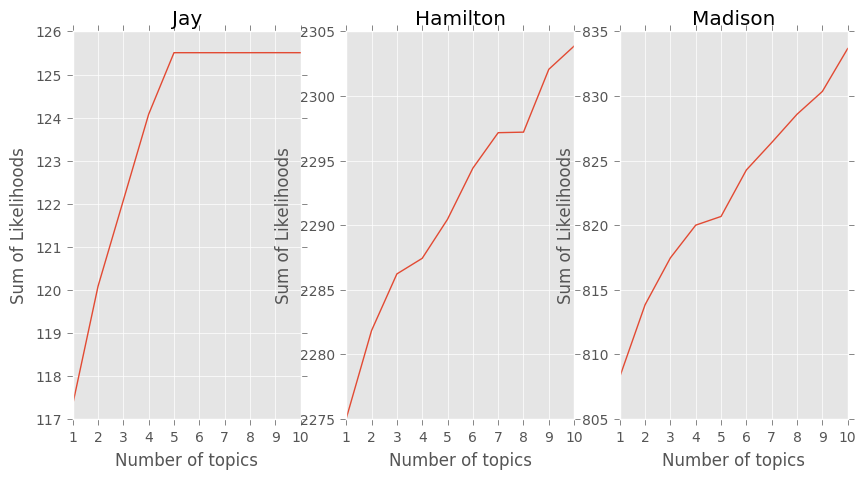

In [267]:
# Likelihoods- plotting likelihoods to find optimal
fig = plt.figure(figsize=(10,5))
errors=[]
ind=[]
j=0
for matrix in [jay,hamilton,madison]:
    j+=1
    errors=[]
    ind=[]
    if j==1:
        title="Jay"
    elif j==2:
        title="Hamilton"
    else: 
        title="Madison"
    for i in range(10):
        sample1,sample2=doubleUpdate(i+1,matrix)
        ind.append(i+1)
        errors.append((np.dot(sample1.T,sample2.T)*matrix).sum(axis=1).sum())
        #print(sample1.shape,sample2.shape,matrix.shape)
        #errors.append((np.log(sample1)+np.dot(sample2.T,matrix.T)).sum().sum())
    ax=plt.subplot(1,3,j)
    plt.plot(ind,errors)
    plt.title(title)
    plt.xlabel("Number of topics")
    plt.ylabel("Sum of Likelihoods")
plt.show()

# Results

In [260]:
indices=[]
hamiltons=[]
madisons=[]
tracks=[]
hamiltonsstop=[]
madisonsstop=[]
tracksstop=[]
stopstring=""
for i in range(10):
    madison2=doubleUpdate(i+1,madison)[1]
    madcolumns=[]
    for j in range(i+1):
        madcolumns.append("Madison"+str(j+1))
    madison2.columns=madcolumns
    hamilton2=doubleUpdate(i+1,hamilton)[1]
    hamcolumns=[]
    for j in range(i+1):
        hamcolumns.append("Hamilton"+str(j+1))
    hamilton2.columns=hamcolumns
    jay2=doubleUpdate(i+1,jay)[1]
    jaycolumns=[]
    for j in range(i+1):
        jaycolumns.append("Jay"+str(j+1))
    jay2.columns=jaycolumns
    al=hamilton2.T.append(jay2.T).append(madison2.T)
    al_nu=al.replace(0,.000001)
    result=EM_Algo_LA((i+1)*3,al_nu,unknowns)
    resultstop=EM_Algo_LA((i+1)*3,al_nu[stopwords2],unknowns[stopwords2])
    result.index=al_nu.index
    result=result.T
    result['Hamilton']=0
    result['Madison']=0
    result['Jay']=0
    resultstop.index=al_nu.index
    resultstop=resultstop.T
    resultstop['Hamilton']=0
    resultstop['Madison']=0
    resultstop['Jay']=0
    for j in range(i+1):
        result['Hamilton']=result['Hamilton']+result['Hamilton'+str(j+1)]
        result['Jay']=result['Jay']+result['Jay'+str(j+1)]
        result['Madison']=result['Madison']+result['Madison'+str(j+1)]
        resultstop['Hamilton']=resultstop['Hamilton']+resultstop['Hamilton'+str(j+1)]
        resultstop['Jay']=resultstop['Jay']+resultstop['Jay'+str(j+1)]
        resultstop['Madison']=resultstop['Madison']+resultstop['Madison'+str(j+1)]
    print(i+1)
    print(result[['Hamilton',"Jay","Madison"]])
    stopstring=stopstring+str(i+1)+"\n"
    stopstring=stopstring+str(resultstop[['Hamilton',"Jay","Madison"]])
    indices.append(i+1)
    hamiltons.append(result['Hamilton'].sum())
    madisons.append(result['Madison'].sum())
    tracks.append([result['Hamilton'],result['Jay'],result['Madison']])
    hamiltonsstop.append(resultstop['Hamilton'].sum())
    madisonsstop.append(resultstop['Madison'].sum())
    tracksstop.append([resultstop['Hamilton'],resultstop['Jay'],resultstop['Madison']])
    print("Hamilton"+str(result['Hamilton'].sum()))
    print("Madison"+str(result['Madison'].sum()))

0
0
1
    Hamilton       Jay   Madison
17  0.423455  0.077145  0.499400
18  0.597899  0.039056  0.363044
19  0.556681  0.075902  0.367416
48  0.510549  0.025081  0.464370
49  0.516146  0.030920  0.452934
50  0.348567  0.000204  0.651230
51  0.488396  0.028919  0.482685
52  0.490504  0.087111  0.422385
53  0.456071  0.008548  0.535381
54  0.533264  0.024628  0.442108
55  0.402514  0.078025  0.519460
56  0.548301  0.077063  0.374635
57  0.504811  0.019557  0.475633
61  0.452885  0.089587  0.457528
62  0.440272  0.038432  0.521297
Hamilton7.27031559266698
Madison7.029506628467074
0
0
2
    Hamilton       Jay   Madison
17  0.466570  0.061589  0.471841
18  0.631858  0.020653  0.347489
19  0.572324  0.067252  0.360424
48  0.507623  0.046528  0.445849
49  0.502463  0.042665  0.454872
50  0.353012  0.003758  0.643230
51  0.480629  0.041620  0.477752
52  0.480851  0.106554  0.412595
53  0.488778  0.007369  0.503853
54  0.527596  0.028526  0.443877
55  0.416326  0.089802  0.493872
56  0.557579  

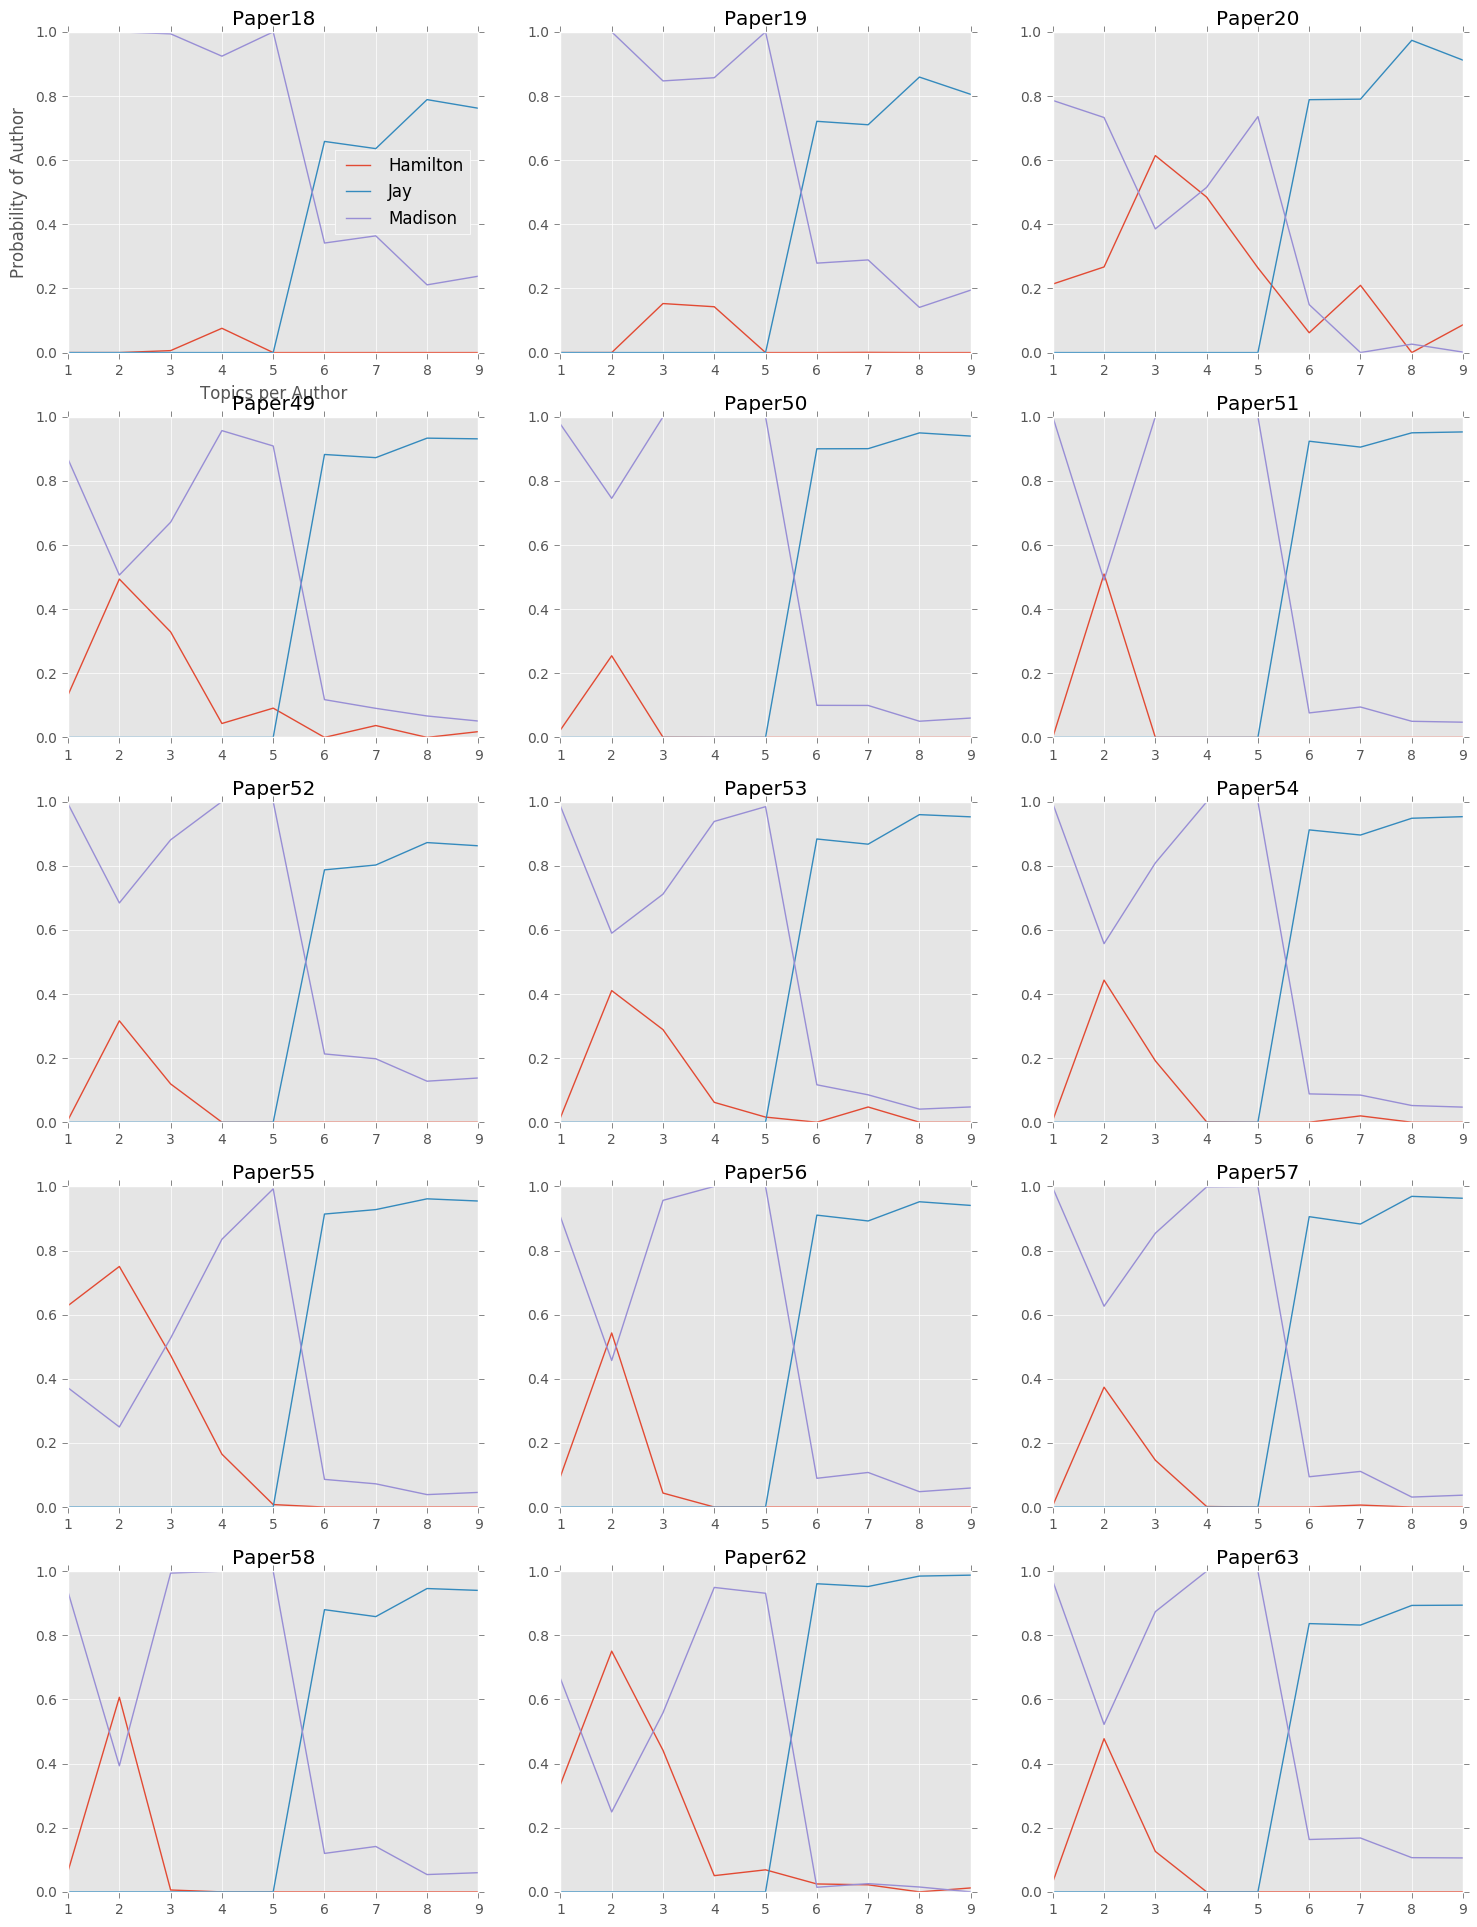

In [263]:
data=[]
hamy=[]
jayy=[]
mady=[]
fig = plt.figure(figsize=(18,24))
k=-1
j=0
h=0
for i in tracksstop[0][0].index:
    k=k+1
    data=[]
    j=j+1
    h=h+1
    for j in range(len(tracksstop)):
        current=[tracksstop[j][0][i],tracksstop[j][1][i],tracksstop[j][2][i]]
        data.append(current)
        hamy.append(tracksstop[j][0][i])
        jayy.append(tracksstop[j][1][i])
        mady.append(tracksstop[j][2][i])
    #print(i)
    ax=plt.subplot(5,3,k+1)
    #print(data)
    #print(data)
    if k!=0:
        pd.DataFrame(data,columns=["Hamilton","Jay","Madison"]).shift().drop(0).plot.line(title="Paper"+str(i+1),ax=ax,legend=False)
    else: 
        plt.ylabel("Probability of Author")
        plt.xlabel("Topics per Author")
        pd.DataFrame(data,columns=["Hamilton","Jay","Madison"]).shift().drop(0).plot.line(title="Paper"+str(i+1),ax=ax)

plt.show()

17
18
19
48
49
50
51
52
53
54
55
56
57
61
62


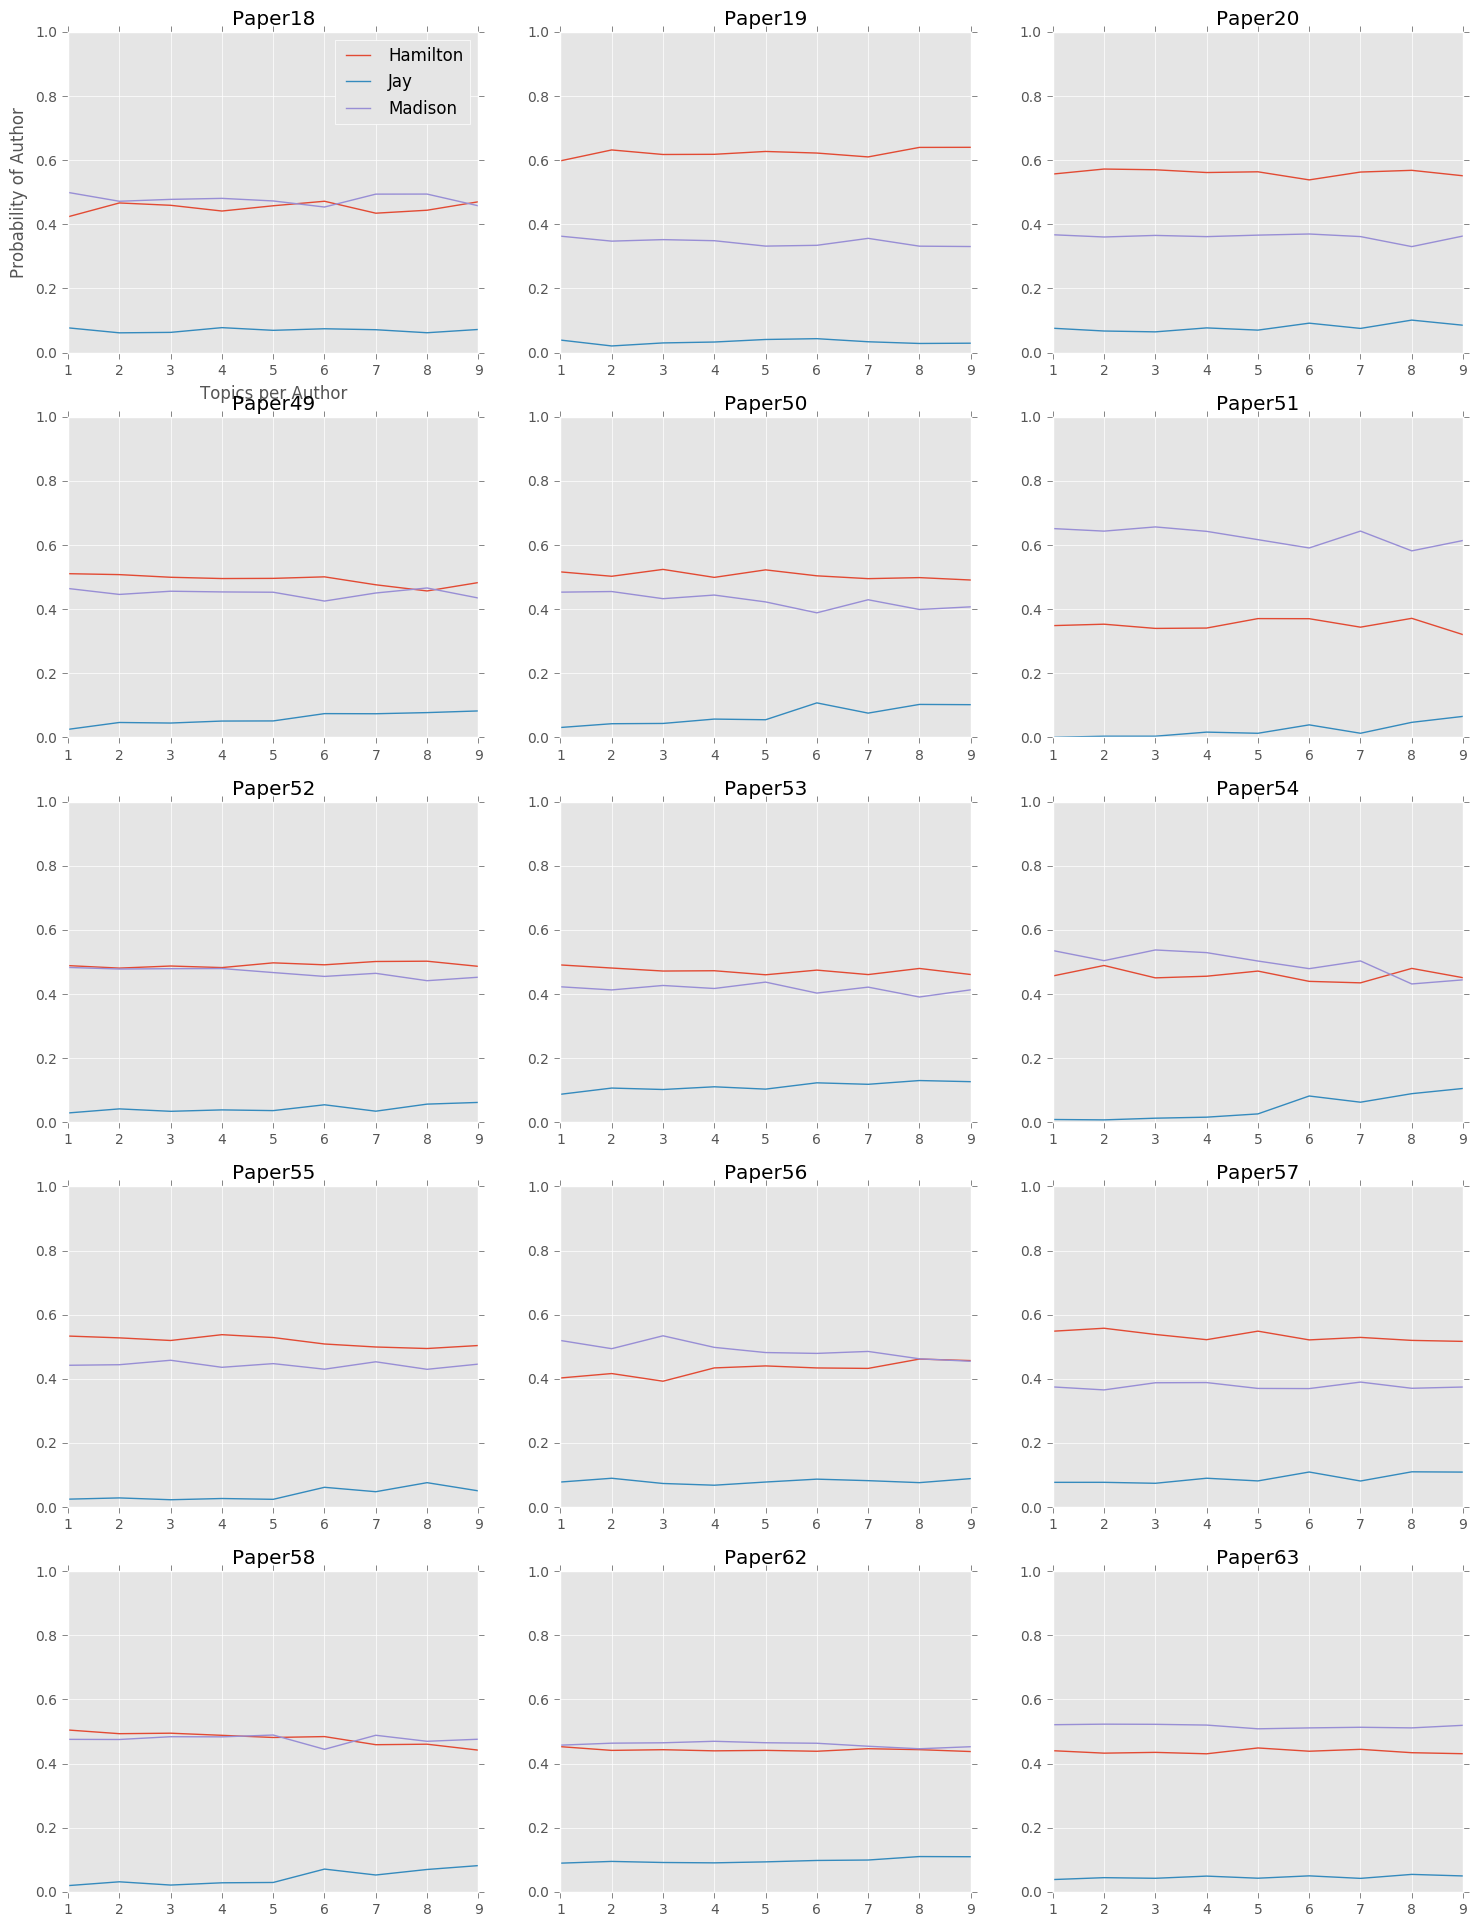

In [266]:
data=[]
hamy=[]
jayy=[]
mady=[]
fig = plt.figure(figsize=(18,24))
k=-1
j=0
h=0
for i in tracks[0][0].index:
    k=k+1
    data=[]
    j=j+1
    h=h+1
    for j in range(len(tracksstop)):
        current=[tracks[j][0][i],tracks[j][1][i],tracks[j][2][i]]
        data.append(current)
        hamy.append(tracks[j][0][i])
        jayy.append(tracks[j][1][i])
        mady.append(tracks[j][2][i])
    print(i)
    ax=plt.subplot(5,3,k+1)
    if k!=0:
        pd.DataFrame(data,columns=["Hamilton","Jay","Madison"]).shift().drop(0).plot.line(title="Paper"+str(i+1),ylim=[0,1],ax=ax,legend=False)
    else:
        plt.ylabel("Probability of Author")
        plt.xlabel("Topics per Author")
        pd.DataFrame(data,columns=["Hamilton","Jay","Madison"]).shift().drop(0).plot.line(title="Paper"+str(i+1),ax=ax,ylim=[0,1])

plt.show()

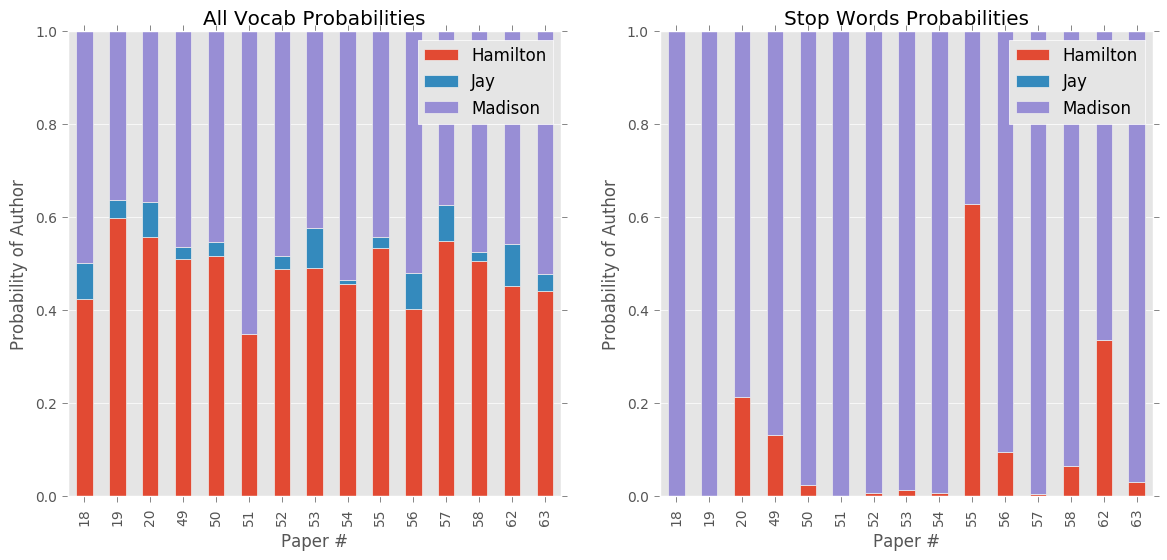

In [257]:
#plt.style.use('ggplot')
fig = plt.figure(figsize=(14,6))
tracks[0][0].index=tracks[0][0].index+1
tracks[0][1].index=tracks[0][1].index+1
tracks[0][2].index=tracks[0][2].index+1
ax=plt.subplot(1,2,1)
pd.DataFrame([tracks[0][0],tracks[0][1],tracks[0][2]],columns=tracks[0][0].index).T.plot.bar(stacked=True,ax=ax,title="All Vocab Probabilities")
plt.xlabel("Paper #")
plt.ylabel("Probability of Author")
tracksstop[0][0].index=tracksstop[0][0].index+1
tracksstop[0][1].index=tracksstop[0][1].index+1
tracksstop[0][2].index=tracksstop[0][2].index+1
ax=plt.subplot(1,2,2)
pd.DataFrame([tracksstop[0][0],tracksstop[0][1],tracksstop[0][2]],columns=tracksstop[0][0].index).T.plot.bar(stacked=True,ax=ax,title="Stop Words Probabilities")
plt.xlabel("Paper #")
plt.ylabel("Probability of Author")

In [697]:
print(stopstring)

1
        Hamilton           Jay   Madison
17  1.068251e-15  2.803930e-55  1.000000
18  6.990710e-07  2.933366e-46  0.999999
19  2.136628e-01  2.185290e-43  0.786337
48  1.324679e-01  2.302350e-56  0.867532
49  2.315502e-02  1.167950e-37  0.976845
50  4.638468e-05  2.432082e-53  0.999954
51  7.325007e-03  1.376482e-50  0.992675
52  1.420000e-02  1.903520e-45  0.985800
53  5.988281e-03  1.627661e-53  0.994012
54  6.282189e-01  1.049164e-45  0.371781
55  9.494698e-02  4.075388e-39  0.905053
56  4.673828e-03  9.360866e-50  0.995326
57  6.483463e-02  8.850118e-51  0.935165
61  3.348856e-01  2.285428e-46  0.665114
62  3.059333e-02  1.103629e-54  0.9694072
        Hamilton           Jay   Madison
17  1.802179e-13  5.368854e-30  1.000000
18  3.096023e-03  3.564786e-24  0.996904
19  3.283381e-01  3.584063e-16  0.671662
48  2.882101e-01  4.661378e-30  0.711790
49  3.476013e-03  4.401942e-16  0.996524
50  9.095088e-02  3.250182e-29  0.909049
51  4.851779e-02  1.425462e-22  0.951482
52  1.736862e

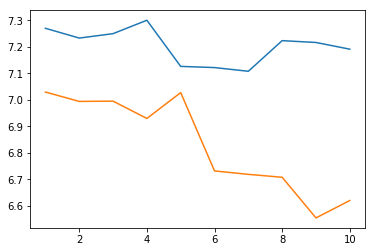

In [693]:

plt.plot(indices,hamiltons)
plt.plot(indices,madisons)

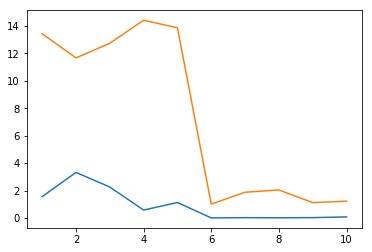

In [694]:
# 15 different 
plt.plot(indices,hamiltonsstop)
plt.plot(indices,madisonsstop)

In [699]:
pwa_nu=pwa.replace(0,.000001)
#EM_Algo_LA(3,pwa_nu,unknowns)

In [549]:
unknowns=catCount[~catCount['Author'].isin(['Hamilton','Madison','Jay'])].drop(["Paper","Author"],axis=1)

In [470]:
test=pd.DataFrame(pd.Series([.333333,.333333,.3333333])).T
for i in catCount[~catCount['Author'].isin(['Hamilton','Madison','Jay'])].index:
    print(i+1)
    document=catCount.iloc[i,].drop(["Paper",'Author'])[catCount.iloc[i,].drop(["Paper",'Author'])!=0]
    print(EM_Algo(test,pwa,document))

18


/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


         0         1         2
0  0.44957  0.074737  0.475694
19
          0         1         2
0  0.613701  0.036804  0.349494
20
          0         1         2
0  0.571701  0.071772  0.356527
49
          0        1         2
0  0.525276  0.02331  0.451413
50
          0         1         2
0  0.535059  0.028159  0.436781
51
         0         1         2
0  0.36549  0.004115  0.630395
52
          0         1         2
0  0.505964  0.030901  0.463135
53
          0         1         2
0  0.505233  0.083714  0.411053
54
          0        1         2
0  0.472655  0.00963  0.517715
55
          0         1         2
0  0.548945  0.022932  0.428123
56
         0         1         2
0  0.41631  0.074747  0.508943
57
          0         1         2
0  0.561436  0.076149  0.362415
58
          0         1         2
0  0.519733  0.021843  0.458424
62
          0         1         2
0  0.479044  0.086357  0.434599
63
          0         1         2
0  0.457338  0.038273  0.504389


In [471]:
for i in catCount[catCount['Author'].isin(['Hamilton','Madison','Jay'])].index:
    print(i+1)
    print(catCount.iloc[i,]['Author'])
    document=catCount.iloc[i,].drop(["Paper",'Author'])[catCount.iloc[i,].drop(["Paper",'Author'])!=0]
    print(EM_Algo(test,pwa,document))

1
Hamilton
        0         1         2
0  0.9241  0.074829  0.001071
2
Jay
         0         1         2
0  0.00007  0.999682  0.000248
3
Jay
        0         1         2
0  0.0001  0.999803  0.000097
4
Jay
          0         1         2
0  0.000086  0.999863  0.000051
5
Jay
          0         1         2
0  0.000116  0.999852  0.000032
6
Hamilton
          0         1         2
0  0.919377  0.080129  0.000495
7
Hamilton
         0         1         2
0  0.97855  0.021229  0.000222
8
Hamilton
          0         1         2
0  0.948624  0.050525  0.000851
9
Hamilton
          0         1         2
0  0.941423  0.000011  0.058566
10
Madison
          0         1         2
0  0.000134  0.002836  0.997029
11
Hamilton
          0         1         2
0  0.889432  0.110141  0.000427
12
Hamilton
          0         1         2
0  0.999117  0.000261  0.000623
13
Hamilton
          0         1         2
0  0.906949  0.090827  0.002223
14
Madison
          0         1         2
0  0.000006

KeyboardInterrupt: 

In [483]:
stops=pwa[stopwords]
stops2=pwa[stopwords2]
ix=[i for i in pwa.columns if i not in stopwords]
ix2=[i for i in pwa.columns if i not in stopwords2]
nonstops=pwa[ix]
nonstops2=pwa[ix2]

In [478]:
test=pd.DataFrame(pd.Series([.333333,.333333,.3333333])).T
for i in catCount[~catCount['Author'].isin(['Hamilton','Madison','Jay'])].index:
    print(i+1)
    document=catCount.iloc[i,].drop(["Paper",'Author'])
    document=document[stopwords]
    #print(document)
    print(EM_Algo(test,stops,documentstop))

18
          0         1         2
0  0.090609  0.015349  0.894042
19
          0             1         2
0  0.136391  4.307700e-09  0.863609
20
          0        1         2
0  0.363589  0.01412  0.622291
49
          0         1         2
0  0.655601  0.004468  0.339931
50
          0         1         2
0  0.284567  0.082254  0.633179
51
          0             1         2
0  0.237629  2.506763e-09  0.762371
52
         0         1         2
0  0.29145  0.000066  0.708484
53
          0         1         2
0  0.230322  0.034296  0.735382
54
          0         1        2
0  0.373567  0.004412  0.62202
55
          0         1         2
0  0.762932  0.096962  0.140107
56
          0         1         2
0  0.297268  0.000046  0.702686
57
         0         1         2
0  0.44102  0.119164  0.439816
58
          0         1         2
0  0.458018  0.000054  0.541929
62
          0         1         2
0  0.552764  0.014479  0.432757
63
         0         1         2
0  0.50543  0.001672

In [485]:
test=pd.DataFrame(pd.Series([.333333,.333333,.3333333])).T
for i in catCount[~catCount['Author'].isin(['Hamilton','Madison','Jay'])].index:
    print(i+1)
    document=catCount.iloc[i,].drop(["Paper",'Author'])
    document=document[stopwords2]
    #print(document)
    print(EM_Algo(test,stops2,document))

18
         0             1        2
0  0.00143  1.822248e-10  0.99857
19
          0             1         2
0  0.003771  3.426010e-16  0.996229
20
          0             1         2
0  0.220227  4.796590e-20  0.779773
49
          0             1         2
0  0.141858  5.384968e-36  0.858142
50
          0             1         2
0  0.032712  3.173630e-28  0.967288
51
          0             1         2
0  0.005665  2.234476e-24  0.994335
52
          0             1         2
0  0.017151  4.070384e-35  0.982849
53
          0             1         2
0  0.022263  5.323449e-36  0.977737
54
         0             1        2
0  0.01548  3.026205e-37  0.98452
55
          0             1         2
0  0.621967  1.509156e-17  0.378033
56
          0             1         2
0  0.102441  1.070745e-31  0.897559
57
          0             1         2
0  0.014175  1.427330e-33  0.985825
58
          0             1         2
0  0.072229  1.265851e-41  0.927771
62
          0             1     

In [479]:
test=pd.DataFrame(pd.Series([.333333,.333333,.3333333])).T
for i in catCount[~catCount['Author'].isin(['Hamilton','Madison','Jay'])].index:
    print(i+1)
    document=catCount.iloc[i,].drop(["Paper",'Author'])
    document=document[ix]
    #document=document[document!=0]
    #documentnonstop=document[ix]
    #print(document)
    pwaix=pwa[ix]
    print(EM_Algo(test,pwaix,document))

18


/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


          0         1         2
0  0.500303  0.076718  0.422979
19
          0         1        2
0  0.641649  0.047421  0.31093
20
          0         1         2
0  0.589117  0.074813  0.336069
49
         0         1         2
0  0.50607  0.031262  0.462667
50
          0         1         2
0  0.568343  0.020319  0.411338
51
          0         1       2
0  0.368608  0.018692  0.6127
52
         0         1         2
0  0.52909  0.038247  0.432663
53
         0         1         2
0  0.53291  0.085108  0.381982
54
          0         1         2
0  0.488474  0.009368  0.502158
55
          0         1         2
0  0.525195  0.015276  0.459529
56
          0         1         2
0  0.412988  0.098278  0.488734
57
          0         1         2
0  0.577311  0.071436  0.351253
58
          0         1         2
0  0.519976  0.033902  0.446122
62
          0        1         2
0  0.469722  0.09606  0.434218
63
          0         1         2
0  0.446485  0.051871  0.501644


In [484]:
test=pd.DataFrame(pd.Series([.333333,.333333,.3333333])).T
for i in catCount[~catCount['Author'].isin(['Hamilton','Madison','Jay'])].index:
    print(i+1)
    document=catCount.iloc[i,].drop(["Paper",'Author'])
    document=document[ix2]
    #document=document[document!=0]
    #documentnonstop=document[ix]
    #print(document)
    pwaix=pwa[ix2]
    print(EM_Algo(test,pwaix,document))

18


/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


         0         1         2
0  0.48206  0.105071  0.412869
19
         0         1         2
0  0.63488  0.059664  0.305456
20
          0         1         2
0  0.566431  0.106593  0.326977
49
         0         1         2
0  0.50471  0.083991  0.411299
50
          0         1         2
0  0.544035  0.052918  0.403047
51
         0         1         2
0  0.37128  0.037432  0.591288
52
          0         1         2
0  0.516083  0.061145  0.422771
53
          0         1         2
0  0.492671  0.135058  0.372272
54
          0         1        2
0  0.472549  0.049981  0.47747
55
          0         1         2
0  0.518365  0.068157  0.413477
56
          0         1         2
0  0.396644  0.126091  0.477265
57
          0         1         2
0  0.566659  0.115063  0.318278
58
          0         1         2
0  0.523495  0.052132  0.424373
62
          0         1         2
0  0.459556  0.133538  0.406906
63
          0         1         2
0  0.454466  0.077295  0.468239


In [315]:
print(19)
document=catCount.iloc[19,].drop(["Paper",'Author'])
#documentnonstop=document[ix]
#print(document)
pwaix=pwa[ix]
#print(EM_Algo(test,pwaix,document))

19
